### 作業目的: 實作word2vec Skip-gram模型
在課程中了解如何搭建CBOW模型，這次的作業目的在於透過搭建Skip-gram模型來了解另外一種word2vec的架構。

Hint_1: 學員可以善用課程中以搭建好的function模組
Hint_2: Skip_gram所需的輸入資料與目標跟CBOW有些許不同，Skip_gram是由中間字詞預測上下文

In [1]:
# import modules
import numpy as np
from typing import List
from utils.utility import clip_grads, convert_one_hot, preprocess, Trainer
from utils.layers import Dense, SoftmaxWithCrossEntropy
from utils.optimizer import SGD

In [2]:
# use the same corpus as in the lecture
text = "I am studying Natural Language Processing now."

# define create_contexts_target function
def create_contexts_target(corpus: List, window_size: int=1):

    contexts = corpus[window_size:-window_size]
    targets = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                # skip target word itself
                continue
            cs.append(corpus[idx + t])
        targets.append(cs)

    return np.array(contexts), np.array(targets)

# transform corpus to contexts and targets pair
corpus, word2idx, idx2word = preprocess([text])
contexts, targets= create_contexts_target(corpus[0], window_size=1)
contexts, targets

(array([3, 2, 7, 6, 4, 5]),
 array([[0, 2],
        [3, 7],
        [2, 6],
        [7, 4],
        [6, 5],
        [4, 1]]))

In [3]:
# transform contexts and targets to one-hot encoding
contexts = convert_one_hot(contexts, len(word2idx))
targets = convert_one_hot(targets, len(word2idx))
contexts, targets

(array([[0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0]]),
 array([[[1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0, 0]],
 
        [[0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1]],
 
        [[0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0]],
 
        [[0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 1, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 1, 0, 0]],
 
        [[0, 0, 0, 0, 1, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0]]]))

In [4]:
# define Skip-gram model
class SkipGram:
    def __init__(self, vocab_size, hidden_size, window_size):
        V, H = vocab_size, hidden_size
        self.window_size = window_size

        # initialize weights
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')


        # create layers
        self.in_layer = Dense(W_in)
        self.out_layer = Dense(W_out)
        self.loss_layers = [SoftmaxWithCrossEntropy() for i in range(window_size*2)]
        

        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        # word vector matrix
        self.word_vecs = W_in

    def forward(self, contexts, targets):
        h = self.in_layer.forward(contexts)
        s = self.out_layer.forward(h)
        
        loss = sum([self.loss_layers[i].forward(s, targets[:, i]) for i in range(self.window_size*2)])
        return loss

    def backward(self, dout=1):
        
        ds = sum([self.loss_layers[i].backward(dout) for i in range(self.window_size*2)])
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        
        return None

In [5]:
# start training

# configurations
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

# define model
skip_gram = SkipGram(vocab_size=len(word2idx), hidden_size=hidden_size, window_size=window_size)
sgd_optimizer = SGD()
trainer = Trainer(skip_gram, sgd_optimizer)

# start training
trainer.fit(contexts, targets, max_epoch, batch_size)

 37%|███▋      | 368/1000 [00:00<00:00, 1613.71it/s]

Epoch: 1, Iteration: 1/2, Loss: 4.158793335838588
Epoch: 2, Iteration: 1/2, Loss: 4.158717931141709
Epoch: 3, Iteration: 1/2, Loss: 4.158721461474125
Epoch: 4, Iteration: 1/2, Loss: 4.158697096519804
Epoch: 5, Iteration: 1/2, Loss: 4.158650272530644
Epoch: 6, Iteration: 1/2, Loss: 4.158550551831015
Epoch: 7, Iteration: 1/2, Loss: 4.1585347161165975
Epoch: 8, Iteration: 1/2, Loss: 4.158521585511199
Epoch: 9, Iteration: 1/2, Loss: 4.15836739158572
Epoch: 10, Iteration: 1/2, Loss: 4.158280823187017
Epoch: 11, Iteration: 1/2, Loss: 4.158405957586847
Epoch: 12, Iteration: 1/2, Loss: 4.158217137763336
Epoch: 13, Iteration: 1/2, Loss: 4.158008685335609
Epoch: 14, Iteration: 1/2, Loss: 4.158013646637681
Epoch: 15, Iteration: 1/2, Loss: 4.15807615661967
Epoch: 16, Iteration: 1/2, Loss: 4.157690862871304
Epoch: 17, Iteration: 1/2, Loss: 4.15774735863513
Epoch: 18, Iteration: 1/2, Loss: 4.157343624501296
Epoch: 19, Iteration: 1/2, Loss: 4.1573586505052
Epoch: 20, Iteration: 1/2, Loss: 4.157371987

 58%|█████▊    | 578/1000 [00:00<00:00, 1733.92it/s]

Epoch: 380, Iteration: 1/2, Loss: 1.406786446575292
Epoch: 381, Iteration: 1/2, Loss: 1.4045022762004833
Epoch: 382, Iteration: 1/2, Loss: 1.404867749015946
Epoch: 383, Iteration: 1/2, Loss: 1.40458350889963
Epoch: 384, Iteration: 1/2, Loss: 1.4039831086726842
Epoch: 385, Iteration: 1/2, Loss: 1.4062622305056571
Epoch: 386, Iteration: 1/2, Loss: 1.4037320765062096
Epoch: 387, Iteration: 1/2, Loss: 1.4047970979725728
Epoch: 388, Iteration: 1/2, Loss: 1.4037446502023077
Epoch: 389, Iteration: 1/2, Loss: 1.406279556123897
Epoch: 390, Iteration: 1/2, Loss: 1.403133883172346
Epoch: 391, Iteration: 1/2, Loss: 1.4036459449857495
Epoch: 392, Iteration: 1/2, Loss: 1.4041694358827193
Epoch: 393, Iteration: 1/2, Loss: 1.404135173770808
Epoch: 394, Iteration: 1/2, Loss: 1.403667074527204
Epoch: 395, Iteration: 1/2, Loss: 1.4051423031610097
Epoch: 396, Iteration: 1/2, Loss: 1.402193320321138
Epoch: 397, Iteration: 1/2, Loss: 1.4046736044542754
Epoch: 398, Iteration: 1/2, Loss: 1.4025889318949716
Ep

100%|██████████| 1000/1000 [00:00<00:00, 2009.37it/s]

Epoch: 783, Iteration: 1/2, Loss: 1.391841521552732
Epoch: 784, Iteration: 1/2, Loss: 1.3918067110159402
Epoch: 785, Iteration: 1/2, Loss: 1.392527810712233
Epoch: 786, Iteration: 1/2, Loss: 1.3913973267629645
Epoch: 787, Iteration: 1/2, Loss: 1.392184217296409
Epoch: 788, Iteration: 1/2, Loss: 1.3914930100692242
Epoch: 789, Iteration: 1/2, Loss: 1.3913921239092795
Epoch: 790, Iteration: 1/2, Loss: 1.3921848620251245
Epoch: 791, Iteration: 1/2, Loss: 1.3916561971268415
Epoch: 792, Iteration: 1/2, Loss: 1.3915533436621943
Epoch: 793, Iteration: 1/2, Loss: 1.3917367701661414
Epoch: 794, Iteration: 1/2, Loss: 1.391894818187742
Epoch: 795, Iteration: 1/2, Loss: 1.3917431308340644
Epoch: 796, Iteration: 1/2, Loss: 1.391410066975928
Epoch: 797, Iteration: 1/2, Loss: 1.3919905165827293
Epoch: 798, Iteration: 1/2, Loss: 1.3916461858081957
Epoch: 799, Iteration: 1/2, Loss: 1.391708495791634
Epoch: 800, Iteration: 1/2, Loss: 1.3916412909023297
Epoch: 801, Iteration: 1/2, Loss: 1.391677052910852


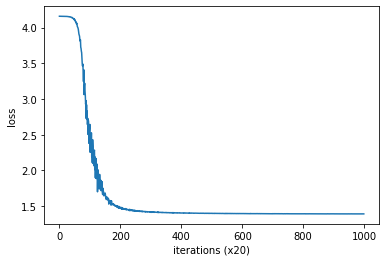

In [6]:
trainer.plot()

In [7]:
# check skip-gram results
word_vecs = skip_gram.word_vecs
for word_id, word in idx2word.items():
    print(word, word_vecs[word_id])

i [0.01360973 0.00167345 0.00893296 0.00441627 0.01900952]
. [ 0.01056854  0.01121181 -0.01240903 -0.03499134  0.00082884]
studying [ 0.5505567 -0.5995957  0.4565048  1.6232542  2.2350442]
am [ 0.36839098  1.6294551   1.0122272  -2.0537248   0.44047657]
processing [ 1.7923493  -0.44799238 -1.8247      0.81297845 -0.8851174 ]
now [-2.1503465  -0.38527468  0.87410265 -0.24294354 -1.5840298 ]
language [-2.1113026  -0.6573507   0.34680322  2.1488106   0.4554852 ]
natural [ 1.3451251  0.4207187 -1.5309942 -2.280155  -0.9962303]
